In [2]:
from __future__ import division
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from datetime import datetime



In [3]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('ggplot')

In [3]:
gdelt_query = """
SELECT Actor1Geo_CountryCode, QuadClass, SQLDATE, SUM(NumArticles) AS NumArticles
FROM [gdelt-bq:full.events]
WHERE (Actor1Geo_CountryCode==ActionGeo_CountryCode) AND (DATE(TIMESTAMP(STRING([SQLDATE]))) >= '2018-01-01')
GROUP BY Actor1Geo_CountryCode, QuadClass, SQLDATE  
ORDER BY Actor1Geo_CountryCode, QuadClass, SQLDATE """

In [4]:
from google.cloud import bigquery
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    'project-271420-fb39868c06f1.json')
project_id = 'project-271420'
client = bigquery.Client(credentials= credentials,project=project_id)


In [5]:

start = datetime.now()
query_job = client.query(gdelt_query)
print('Query done in {}s\n'.format(datetime.now()-start))

Query done in 0:00:02.927085s



In [12]:
import pandas

start = datetime.now()

sql = """
SELECT Actor1Geo_CountryCode, QuadClass, SQLDATE, SUM(NumArticles) AS NumArticles
FROM [gdelt-bq:full.events]
WHERE (Actor1Geo_CountryCode==ActionGeo_CountryCode) AND (DATE(TIMESTAMP(STRING([SQLDATE]))) >= '2005-01-01')
GROUP BY Actor1Geo_CountryCode, QuadClass, SQLDATE  
ORDER BY Actor1Geo_CountryCode, QuadClass, SQLDATE """

query_config = bigquery.QueryJobConfig(use_legacy_sql=True)

df = client.query(sql, job_config=query_config).to_dataframe()
print('Query done in {}s\n'.format(datetime.now()-start))

Query done in 0:04:02.715435s



In [5]:
df.describe()
df.to_pickle('./tf_gdelt_quad_countries_2005_now.pkl')

NameError: name 'df' is not defined

In [3]:
gdelt_df = pd.read_pickle('./tf_gdelt_quad_countries_2005_now.pkl')
print(gdelt_df.info())
gdelt_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3787586 entries, 0 to 3787585
Data columns (total 4 columns):
Actor1Geo_CountryCode    object
QuadClass                int64
SQLDATE                  int64
NumArticles              int64
dtypes: int64(3), object(1)
memory usage: 115.6+ MB
None


,QuadClass,SQLDATE,NumArticles
count,3.787586e+06,3.787586e+06,3.787586e+06
mean,2.408438e+00,2.012829e+07,1.359138e+03
std,1.135316e+00,4.260130e+04,1.289000e+04
min,1.000000e+00,2.005010e+07,1.000000e+00
25%,1.000000e+00,2.009092e+07,2.000000e+01
50%,2.000000e+00,2.013073e+07,8.200000e+01
75%,3.000000e+00,2.016120e+07,4.050000e+02
max,4.000000e+00,2.020033e+07,1.294758e+06


In [4]:
def date_from_int(date_int):
  date_str = str(date_int)
  date = pd.to_datetime(date_str, format='%Y%m%d')
  return date


# Make a new index with date
gdelt_df['Date'] = gdelt_df['SQLDATE'].apply(date_from_int)
gdelt_df.index = gdelt_df['Date']
gdelt_df.drop(['SQLDATE'], axis=1, inplace=True)

In [6]:

gdelt_df.to_pickle('./tf_gdelt_quad_countries_2005p_now.pkl')

In [4]:
gdelt_df = pd.read_pickle('./tf_gdelt_quad_countries_2005p_now.pkl')
print(gdelt_df.info())
gdelt_df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3787586 entries, 2005-01-31 to 2020-03-31
Data columns (total 4 columns):
Actor1Geo_CountryCode    object
QuadClass                int64
NumArticles              int64
Date                     datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 144.5+ MB
None


,QuadClass,NumArticles
count,3787586.00,3787586.00
mean,2.41,1359.14
std,1.14,12890.00
min,1.00,1.00
25%,1.00,20.00
50%,2.00,82.00
75%,3.00,405.00
max,4.00,1294758.00


In [5]:
def split_events(gdelt_df, measure_name = 'NumArticles', country = 'US'):
  event_root_codes = gdelt_df.QuadClass.unique()
  event_series = [gdelt_df[(gdelt_df.QuadClass==event_code) & (gdelt_df.Actor1Geo_CountryCode==country)][[measure_name]]
                 for event_code in event_root_codes]
  event_by_codes = pd.concat(event_series, axis=1).sort_index()
  event_by_codes.columns = map(str, event_root_codes)
  event_by_codes = event_by_codes.fillna(method='ffill')
  event_by_codes = event_by_codes.fillna(method='bfill')
  return event_by_codes


event_by_codes = split_events(gdelt_df)

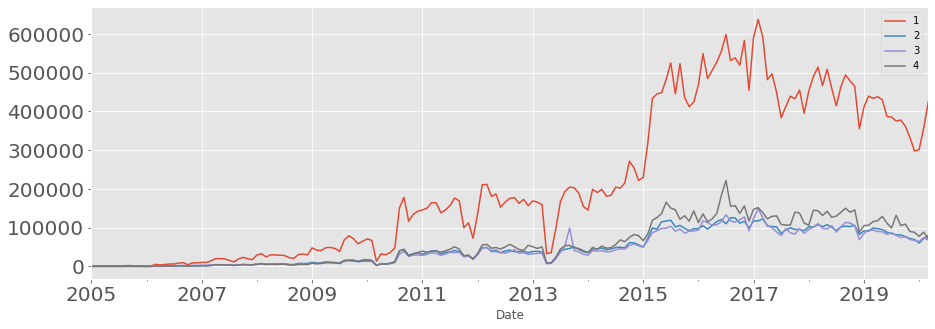

In [6]:
_ = event_by_codes.resample(rule='1M').mean().plot(figsize=(15, 5), fontsize=20)
#Articles per month for each quad class

In [7]:
def log_scale_dataframe(df):
  new_df = pd.DataFrame()
  for col in df.columns:
    new_df[col] = np.log(df[col] / df[col].shift() )
  return new_df

event_by_codes_log = log_scale_dataframe(event_by_codes)

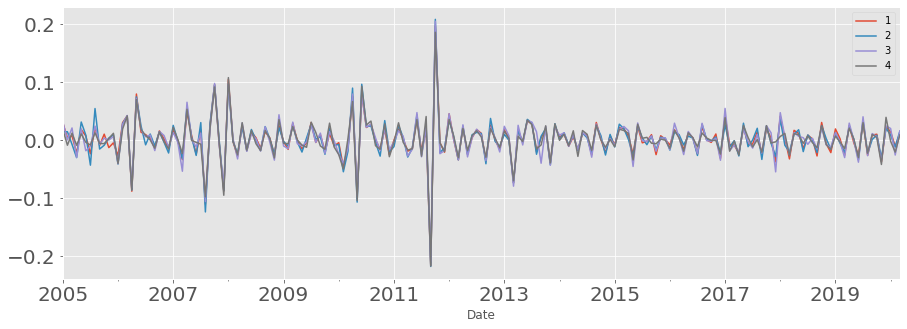

In [8]:
_ = event_by_codes_log.resample(rule='1M').mean().plot(figsize=(15, 5), fontsize=20)

In [9]:
gdelt_df.head(5)

,Actor1Geo_CountryCode,QuadClass,NumArticles,Date
Date,,,,
2005-01-31,AA,1,18,2005-01-31
2005-02-01,AA,1,29,2005-02-01
2005-02-02,AA,1,6,2005-02-02
2005-03-20,AA,1,24,2005-03-20
2005-04-24,AA,1,5,2005-04-24


In [10]:
X = event_by_codes_log.values
y = event_by_codes_log['4'].shift(periods=-1).values


X = X[1:-1]
y = y[1:-1]

print(X[1:10])
print(y[1:10])

print("X shape: {}, y shape: {}".format(X.shape, y.shape)) 
test_split = int(0.2 * len(X))
X_train = X[:test_split]
y_train = y[:test_split]
X_test = X[test_split:]
y_test = y[test_split:]

[[ 0.54790148  0.63799536  0.52511158  0.15215068]
 [ 0.00782477 -0.09737416  0.2961567   0.14250006]
 [ 0.25278559  0.31015493  0.39272608  0.14743173]
 [-0.01709443 -0.19490034  0.09375497  0.07779299]
 [-0.14627944 -0.12956098 -0.2383362   0.03070866]
 [-0.18675045  0.18376144  0.13167782 -0.05384323]
 [-0.08607461 -0.23399357 -0.19539364 -0.09829335]
 [ 0.4191045   0.27164507 -0.11122564 -0.02375409]
 [-0.08410472  0.0046083   0.20173964  0.01904819]]
[ 0.14250006  0.14743173  0.07779299  0.03070866 -0.05384323 -0.09829335
 -0.02375409  0.01904819 -0.06328145]
X shape: (5567, 4), y shape: (5567,)


In [11]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[4]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [104]:
EPOCHS = 10000

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
9995,0.001190,0.025217,0.001190,0.846938,0.643283,0.846938,9995
9996,0.001333,0.026091,0.001333,0.825569,0.638701,0.825569,9996
9997,0.001165,0.024313,0.001165,0.828330,0.635224,0.828330,9997
9998,0.001360,0.026678,0.001360,0.829169,0.637998,0.829169,9998
9999,0.001312,0.025730,0.001312,0.829414,0.635650,0.829414,9999


In [26]:
y_pred = model.predict(X_test)
print(type(y_pred))

<class 'numpy.ndarray'>


MSE: 0.5941658036947164


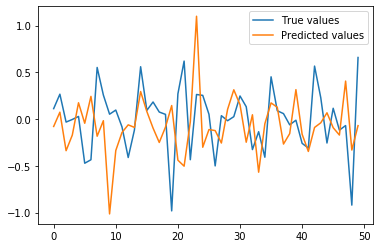

In [21]:
_ = plt.plot(y_test[0:50], label='True values')
_ = plt.plot(y_pred[0:50], label='Predicted values')
plt.legend()
print("MSE: {}".format(metrics.mean_squared_error(y_test, y_pred)))

In [13]:
# Helper function to convert Growth Rate value into class
def value_to_class(x):
  if x<=0:
    return 0.0
  else:
    return 1.0

# Prepare X (all quads classes' Growth Rate) and y (Quad Class '4' - Material Conflict Increase/Decrease)
X = event_by_codes_log.values
y = event_by_codes_log['4'].shift(periods=-1)
y = y.apply(value_to_class).values

# There no info from the past for the very first day.
# Let's drop out first day.
X = X[1:-1]
y = y[1:-1]

# Verify that shape of both sets are compatible
print("X shape: {}, y shape: {}".format(X.shape, y.shape)) 

# Split dataset to Train and Test partion in a ratio 80/20. 
# All model training will be done on Train part, and only evalution will be done on Test part.
test_split = int(0.8 * len(X))
X_train = X[:test_split]
y_train = y[:test_split]
X_test = X[test_split:]
y_test = y[test_split:]

X shape: (5567, 4), y shape: (5567,)


In [14]:
# Helper function to prepare input data for RNN
def rnn_input_fn(x):
  return tf.split(1, 4, x)  # 4 - number of features in X vector

from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_dim=4),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1,  activation='softmax')
  ])

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model




In [15]:
models = build_model()
models.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [29]:
EPOCHS = 100

history = models.fit(
  X_train, encoded_Y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)


In [30]:
# Predict Growth Rate class on Test part
y_pred = models.predict(X_test)

accuracy_score = metrics.accuracy_score(y_test, y_pred)

print("* Classification report *\n{}".format(
        metrics.classification_report(y_test, 
                                      y_pred)))
print("Accuracy on test set: {:.2f}%".format(
        accuracy_score * 100.0))

* Classification report *
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       560
         1.0       0.50      1.00      0.66       554

    accuracy                           0.50      1114
   macro avg       0.25      0.50      0.33      1114
weighted avg       0.25      0.50      0.33      1114

Accuracy on test set: 49.73%


C:\Users\karti\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


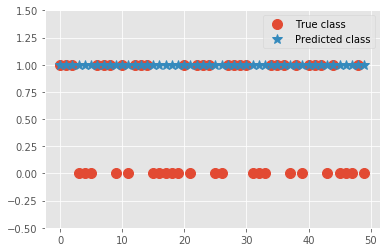

In [28]:
plt.ylim(ymin=-0.5, ymax=1.5)
_ = plt.plot(y_test[0:50], 'o', markersize=10, label='True class')
_ = plt.plot(y_pred[0:50], '*', markersize=10, label='Predicted class')
plt.legend()

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=4, shuffle=True)
results = cross_val_score(estimator, X_train, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Using TensorFlow backend.


Baseline: 61.10% (1.02%)


In [82]:
# evaluate baseline model with standardized dataset

"""
It is a good practice to prepare your data before modeling.
Neural network models are especially suitable to having consistent input values, both in scale and distribution.
An effective data preparation scheme for tabular data when building neural network models is standardization. 
This is where the data is rescaled such that the mean value for each attribute is 0 and the standard deviation is 1. 
This preserves Gaussian and Gaussian-like distributions whilst normalizing the central tendencies for each attribute.
We can use scikit-learn to perform the standardization of our Sonar dataset using the StandardScaler class.
Rather than performing the standardization on the entire dataset, it is good practice to train the 
standardization procedure on the training data within the pass of a cross-validation run and to use the trained 
standardization to prepare the “unseen” test fold. This makes standardization a step in model preparation in the 
cross-validation process and it prevents the algorithm having knowledge of “unseen” data during evaluation, 
knowledge that might be passed from the data preparation scheme like a crisper distribution.

We can achieve this in scikit-learn using a Pipeline. 
The pipeline is a wrapper that executes one or more models within a pass of the cross-validation procedure.
Here, we can define a pipeline with the StandardScaler followed by our neural network model.
"""


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=4, shuffle=True)
results = cross_val_score(pipeline, X_train, encoded_Y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 62.63% (1.15%)


In [83]:
"""suspect that there is a lot of redundancy in the input variables for this problem.
The data describes the same signal from different angles. 
Perhaps some of those angles are more relevant than others.
We can force a type of feature extraction by the network by 
restricting the representational space in the first hidden layer.

In this experiment, we take our baseline model with 60 neurons in the hidden layer and reduce it by half to 30. 
This will put pressure on the network during training to pick out the most important structure in the input data to model.

We will also standardize the data as in the previous experiment with data preparation and try to take advantage of the small lift in performance.
"""
# smaller model
def create_smaller():
    # create model
    model = Sequential()
    model.add(Dense(30, input_dim=4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, encoded_Y, cv=kfold)
print("Smaller: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Smaller: 61.73% (1.73%)


In [50]:
"""A neural network topology with more layers offers more opportunity for the network to extract key features and 
recombine them in useful nonlinear ways.

We can evaluate whether adding more layers to the network improves the performance easily by making another 
small tweak to the function used to create our model. Here, we add one new layer (one line) to the network 
that introduces another hidden layer with 30 neurons after the first hidden layer.
"""

def create_larger():
    # create model
    model = Sequential()
    model.add(Dense(14, input_dim=4, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, encoded_Y, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 60.38% (4.79%)


In [23]:
from sklearn import svm
clf = svm.SVC(gamma=0.01, C=100.)
clf.fit(X_train, encoded_Y)
y_pred = clf.predict(X_test)


accuracy_score = metrics.accuracy_score(y_test, y_pred)

print("* Classification report *\n{}".format(
        metrics.classification_report(y_test, 
                                      y_pred)))
print("Accuracy on test set: {:.2f}%".format(
        accuracy_score * 100.0))

* Classification report *
              precision    recall  f1-score   support

         0.0       0.58      0.74      0.65       560
         1.0       0.64      0.47      0.54       554

    accuracy                           0.60      1114
   macro avg       0.61      0.60      0.59      1114
weighted avg       0.61      0.60      0.59      1114

Accuracy on test set: 60.14%


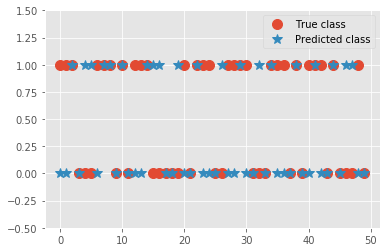

In [26]:
plt.ylim(ymin=-0.5, ymax=1.5)
_ = plt.plot(y_test[0:50], 'o', markersize=10, label='True class')
_ = plt.plot(y_pred[0:50], '*', markersize=10, label='Predicted class')
plt.legend()

In [21]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, encoded_Y)
print(grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.575, total=   0.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.589, total=   0.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.569, total=   0.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.621, total=   0.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.627, total=   0.7s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.548, total=   0.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.549, total=   0.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.538, total=   0.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.580, total=   0.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.612, total=   0.7s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.588, total=   0.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.580, total=   0.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.610, total=   0.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.557, total=   0.8s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.524, total=   0.9s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.526, total=   0.8s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.602, total=   1.0s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.555, total=   1.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.600, total=   0.8s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.589, total=   0.8s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.595, total=   0.9s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.588, total=   0.8s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.552, total=   0.9s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.5min finished


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [32]:
from sklearn.model_selection import RandomizedSearchCV
loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
penalty = ['l1', 'l2', 'elasticnet']
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
eta0 = [1, 10, 100]

param_distributions = dict(loss=loss,
                           penalty=penalty,
                           alpha=alpha,
                           learning_rate=learning_rate,
                           class_weight=class_weight,
                           eta0=eta0)

random = RandomizedSearchCV(estimator=sgd,
                            param_distributions=param_distributions,
                            scoring='roc_auc',
                            verbose=1, n_jobs=-1,
                            n_iter=1000)
random_result = random.fit(X_train, y_train)

print('Best Score: ', random_result.best_score_)
print('Best Params: ', random_result.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2976 tasks      | elapsed:   18.3s


Best Score:  0.6229192166774711
Best Params:  {'penalty': 'l1', 'loss': 'modified_huber', 'learning_rate': 'optimal', 'eta0': 1, 'class_weight': {1: 0.4, 0: 0.6}, 'alpha': 0.0001}


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   29.2s finished


In [24]:
from sklearn.metrics import classification_report, confusion_matrix 
grid_predictions = grid.predict(X_test) 
  
# print classification report 
accuracy_score = metrics.accuracy_score(y_test, y_pred)

print("* Classification report *\n{}".format(
        metrics.classification_report(y_test, 
                                      grid_predictions)))
print("Accuracy on test set: {:.2f}%".format(
        accuracy_score * 100.0))

* Classification report *
              precision    recall  f1-score   support

         0.0       0.62      0.78      0.69       560
         1.0       0.70      0.53      0.60       554

    accuracy                           0.65      1114
   macro avg       0.66      0.65      0.65      1114
weighted avg       0.66      0.65      0.65      1114

Accuracy on test set: 60.14%


In [25]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(random_state=0).fit(X_train, encoded_Y)
y_pred = clf.predict(X_test)


accuracy_score = metrics.accuracy_score(y_test, y_pred)

print("* Classification report *\n{}".format(
        metrics.classification_report(y_test, 
                                      y_pred)))
print("Accuracy on test set: {:.2f}%".format(
        accuracy_score * 100.0))

* Classification report *
              precision    recall  f1-score   support

         0.0       0.56      0.64      0.60       560
         1.0       0.57      0.49      0.53       554

    accuracy                           0.56      1114
   macro avg       0.57      0.56      0.56      1114
weighted avg       0.57      0.56      0.56      1114

Accuracy on test set: 56.46%


In [100]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=4, step=10, verbose=5)
rfe_selector.fit(X_norm, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X[:,rfe_support]
print(str(len(rfe_feature)), 'selected features')

5567 selected features


In [99]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 
from sklearn.preprocessing import MinMaxScaler 
X_norm = MinMaxScaler().fit_transform(X_train) 
chi_selector = SelectKBest(chi2, k=4) 
chi_selector.fit(X_norm, y_train) 
chi_support = chi_selector.get_support() 
chi_feature = X[:,chi_support] 
print(str(len(chi_feature)), 'selected features')

5567 selected features


In [98]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=4)
embeded_lr_selector.fit(X_norm, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X[:,embeded_lr_support]
print(str(len(embeded_lr_feature)), 'selected features')

5567 selected features


In [103]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=4)
embeded_rf_selector.fit(X_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train[:,embeded_rf_support]
print(str(len(embeded_rf_feature)), 'selected features')

4453 selected features
